In [1]:
import numpy as np
import sep

In [2]:
# additional setup for reading the test image and displaying plots
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline

rcParams['figure.figsize'] = [15., 10.]

Read image into 2D numpy array

In [3]:
# read image into standard 2-d numpy array
hdu_1 = fits.open("./MAST/JWST/jw02731-o001_t017_nircam_clear-f090w/jw02731-o001_t017_nircam_clear-f090w_i2d.fits")
#print(hdu_1.info())
data = hdu_1[1].data

# Need to do byteswap operation because astropy.io.fits returns big-endian
# byte order arrays, even on little-endian machines. 
data = data.astype(data.dtype.newbyteorder('='))
print(np.shape(data))

#print(np.nanmin(data))
#print(np.nanmax(data))
#print(data[0:500,0:500])
#plt.plot(data[500])
#plt.show()

(8582, 14339)


In [4]:
def rescale_image(data,vmin=0.5,vmax=100):
    data_tmp = data.copy()

    # find the mean of the data, excluding NaN
    m = np.nanmean(data_tmp)

    # set cutoffs using vmin/vmax
    vpmin = vmin * m
    vpmax = vmax * m
    data_tmp[data_tmp < vpmin] = vpmin
    data_tmp[data_tmp > vpmax] = vpmax
    
    # replace NaN by vpmin
    data_tmp = np.nan_to_num(data_tmp,nan=vpmin)

    # scale using log base 10
    data_tmp = np.log10(data_tmp)
    return data_tmp

In [5]:
# scale the data and take care of NaN
data = rescale_image(data,vmin=0.5,vmax=100)
#print(np.min(data))
#print(np.max(data))

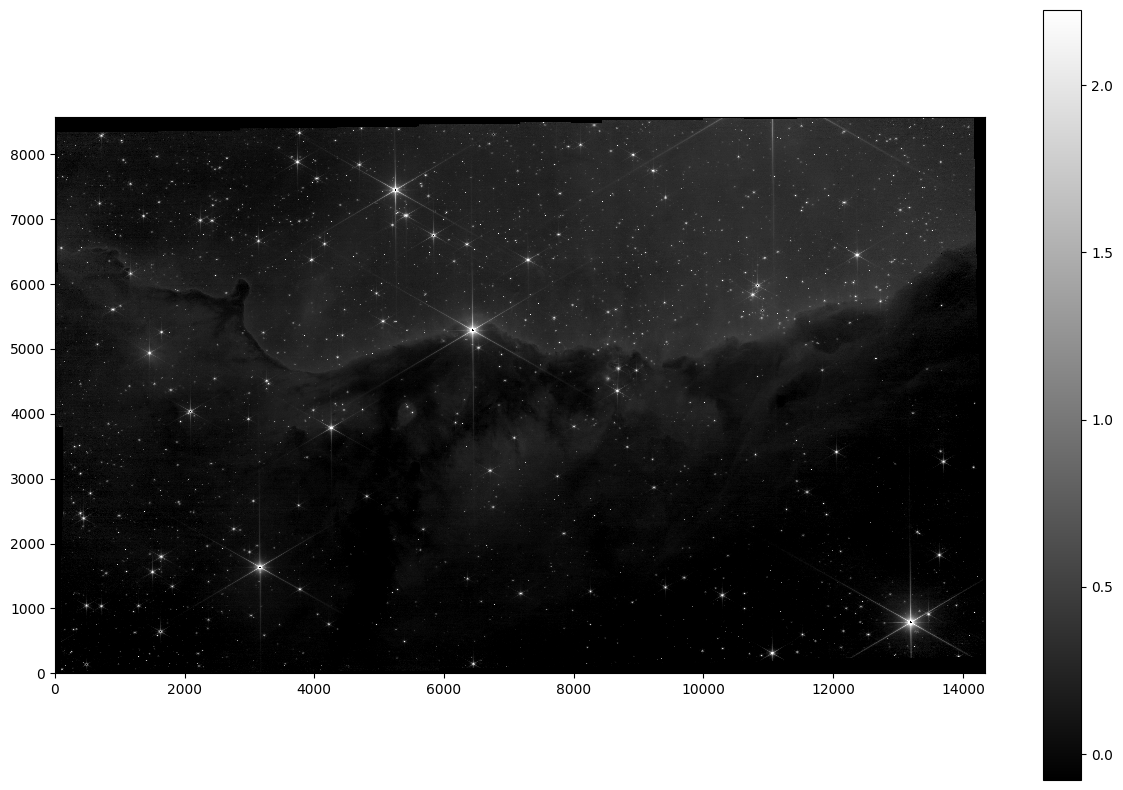

In [6]:
# show the image
# use nanmean and nanstd to ignore nan while seeing the image
#m, s = np.nanmean(data), np.nanstd(data)
#plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.imshow(data, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig('GrayImage.png')

In [7]:
# measure a spatially varying background on the image
#bkg = sep.Background(data)
#bkg = sep.Background(data, mask=None, bw=256, bh=256, fw=3, fh=3)
bkg = sep.Background(data, mask=None, bw=256, bh=256)

In [8]:
print(bkg.globalback)
print(bkg.globalrms)

0.06524530798196793
0.024211300536990166


In [9]:
# evaluate background as 2-d array, same size as original image
bkg_image = bkg.back()
# bkg_image = np.array(bkg) # equivalent to above

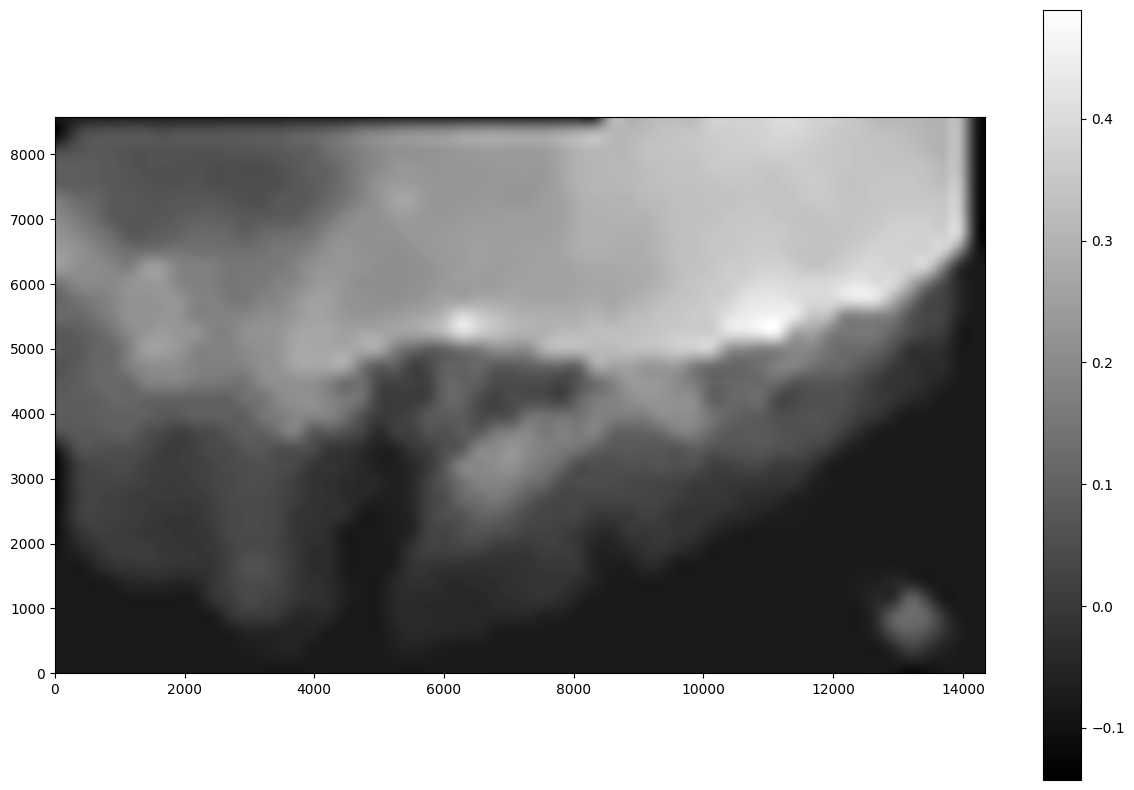

In [10]:
# show the background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig('Background.png')

In [11]:
# evaluate the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()

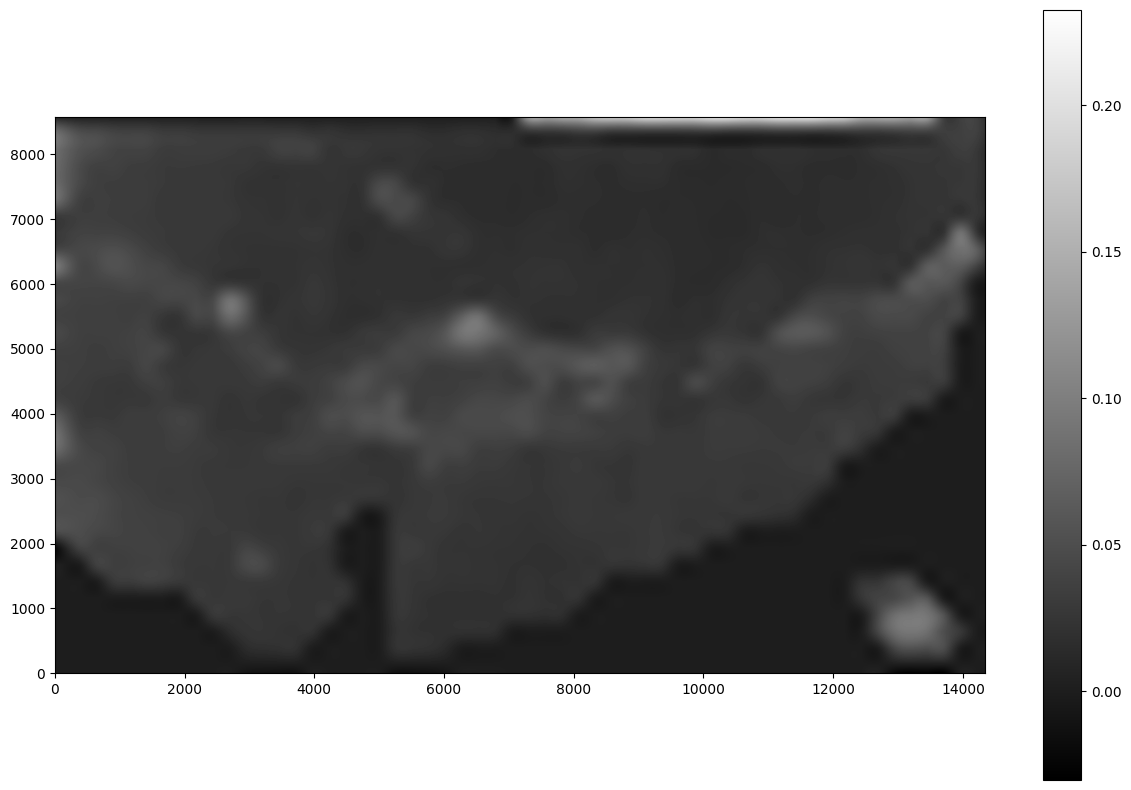

In [12]:
# show the background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig('BackgroundNoise.png')

In [13]:
#subtract the background
data_sub = data - bkg

In [14]:
objects = sep.extract(data_sub, 50, err=bkg.globalrms)

In [15]:
# how many objects were detected
len(objects)

2209

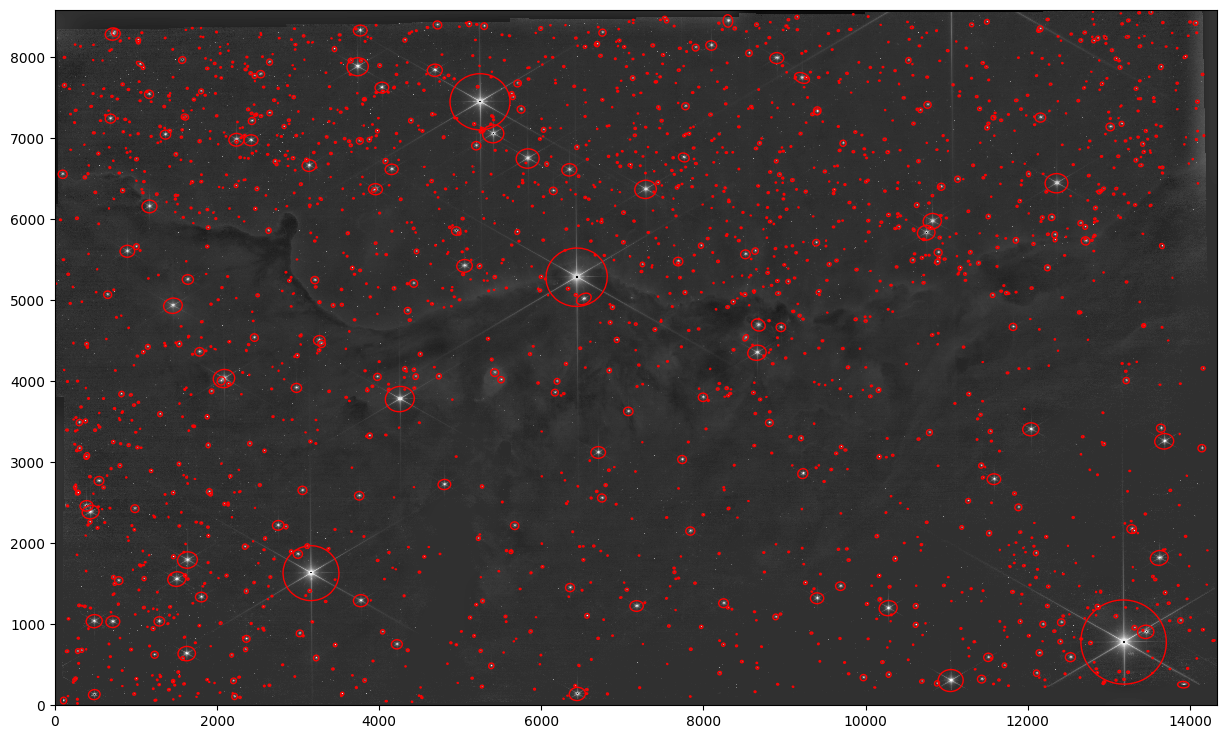

In [16]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
#im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
#               vmin=m-s, vmax=m+s, origin='lower')
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=20*objects['a'][i],
                height=20*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
plt.savefig('IdenitifiedObjects.png')

In [17]:
# available fields
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

In [18]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)

In [19]:
# show the first 10 objects results:
for i in range(69):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 33.901964 +/- 5.823965
object 1: flux = 31.547637 +/- 5.618208
object 2: flux = 37.718353 +/- 6.142871
object 3: flux = 34.979818 +/- 5.915779
object 4: flux = 41.592323 +/- 6.450496
object 5: flux = 54.218162 +/- 7.364419
object 6: flux = 27.418488 +/- 5.237849
object 7: flux = 39.668952 +/- 6.299651
object 8: flux = 27.389524 +/- 5.235081
object 9: flux = 40.761994 +/- 6.385810
object 10: flux = 45.800753 +/- 6.768853
object 11: flux = 28.137045 +/- 5.305999
object 12: flux = 31.765712 +/- 5.637574
object 13: flux = 29.087869 +/- 5.394854
object 14: flux = 27.070743 +/- 5.204541
object 15: flux = 33.015334 +/- 5.747333
object 16: flux = 30.004607 +/- 5.479159
object 17: flux = 54.272386 +/- 7.368100
object 18: flux = 26.988903 +/- 5.196675
object 19: flux = 31.900077 +/- 5.649479
object 20: flux = 50.212516 +/- 7.087249
object 21: flux = 42.445864 +/- 6.516325
object 22: flux = 3.865816 +/- 1.970379
object 23: flux = 55.660164 +/- 7.461688
object 24: flux = 37.632696